In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dgr_bert_model import *
from dgr_vae_model import *
from dgr_utils import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [ ]:
"""
Breaks BertLSTM model into FeatureExtractor and FeatureClassifier

FeatureExtractor -> extract a fixed sized linear representation of a sentence
FeatureClassifier -> classify a sentence based on the fixed sized linear representation

* Features are extracted with FeatureExtractor as tensors and saved in data/
"""

In [4]:
sample_column_name = "string"
columns_to_keep = ['string', 'label', 'citeStart', 'citeEnd']

train_dataset_file_path = "../../data/raw/train.jsonl"
test_dataset_file_path = "../../data/raw/test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

# Load dataset
df_train = load_dataset_raw(train_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)

# {'background': 0, 'method': 1, 'result': 2}
unique_labels = df_train['label'].unique()

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# processing the dataset
print("Processing train dataset...")
texts_train, labels_train = process_data_bert(df_train, label_to_index)

print("Processing test dataset...")
texts_test, labels_test = process_data_bert(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train dataset...


100%|██████████| 8240/8240 [00:00<00:00, 21741.92it/s]


Processing test dataset...


100%|██████████| 1857/1857 [00:00<00:00, 21586.57it/s]

Total number of training samples: 8240
Total number of test samples: 1857


In [7]:
max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

In [8]:
# generate sequence, mask and labels

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [9]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [10]:
model_path = 'data/model_bert_854.pth'
bert_lstm = torch.load(model_path)
print(bert_lstm)

BertLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [11]:
feature_extractor = FeatureExtractor(bert_lstm)
print(feature_extractor)

feature_extractor_path = "data/feature_extractor.pth"
torch.save(feature_extractor, feature_extractor_path)

FeatureExtractor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [12]:
feature_classifier = FeatureClassifier(bert_lstm)
print(feature_classifier)

feature_classifier_path = "data/feature_classifier.pth"
torch.save(feature_classifier, feature_classifier_path)

FeatureClassifier(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [15]:
train_features_sample = torch.tensor([]).to(device)
train_features_label = torch.tensor([]).to(device)

with tqdm(total=len(train_dataloader)) as progress_bar:
    for sent_id, mask, labels in train_dataloader:
        batch_size, seq_len = sent_id.shape[0], sent_id.shape[1]
            
        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)
        
        hidden = feature_extractor.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))
        
        x = feature_extractor(sent_id, mask, hidden)
        
        train_features_sample = torch.cat((train_features_sample, x), dim=0)
        train_features_label = torch.cat((train_features_label, labels), dim=0)
        
        progress_bar.update(1)

100%|██████████| 258/258 [02:11<00:00,  1.96it/s]


In [16]:
print(train_features_sample.shape)
print(train_features_label.shape)

torch.Size([8240, 1024])
torch.Size([8240])


In [17]:
val_features_sample = torch.tensor([]).to(device)
val_features_label = torch.tensor([]).to(device)

with tqdm(total=len(val_dataloader)) as progress_bar:

    for sent_id, mask, labels in val_dataloader:
        batch_size, seq_len = sent_id.shape[0], sent_id.shape[1]
            
        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)
        
        hidden = feature_extractor.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))
        
        x = feature_extractor(sent_id, mask, hidden)
        
        val_features_sample = torch.cat((val_features_sample, x), dim=0)
        val_features_label = torch.cat((val_features_label, labels), dim=0)
        
        progress_bar.update(1)

100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


In [18]:
print(val_features_sample.shape)
print(val_features_label.shape)

torch.Size([1857, 1024])
torch.Size([1857])


In [19]:
train_features_sample_path = 'data/train_features_sample.pt'
torch.save(train_features_sample, train_features_sample_path)

train_features_label_path = 'data/train_features_label.pt'
torch.save(train_features_label, train_features_label_path)

val_features_sample_path = 'data/val_features_sample.pt'
torch.save(val_features_sample, val_features_sample_path)

val_features_label_path = 'data/val_features_label.pt'
torch.save(val_features_label, val_features_label_path)

In [28]:
batch_size = 32

train_features_dataset = TensorDataset(train_features_sample, train_features_label)
train_features_sampler = RandomSampler(train_features_dataset)
train_features_dataloader = DataLoader(train_features_dataset, 
                                  sampler=train_features_sampler, 
                                  batch_size=batch_size)


val_features_dataset = TensorDataset(val_features_sample, val_features_label)
val_features_sampler = RandomSampler(val_features_dataset)
val_features_dataloader = DataLoader(val_features_dataset, 
                                  sampler=val_features_sampler, 
                                  batch_size=batch_size)

In [21]:
for x, y in train_features_dataloader:
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    break

x.shape: torch.Size([32, 1024])
y.shape: torch.Size([32])


In [25]:
y_true_train, y_pred_train = [], []
for x, y in train_features_dataloader:
    x, y = x.to(device), y.to(device)
    
    log_probs = feature_classifier(x)
    
    y_batch_pred = torch.argmax(log_probs, dim=1)
    
    y_true_train += list(y.cpu().numpy())
    y_pred_train += list(y_batch_pred.cpu().numpy())


Evaluation on Training dataset
F1 score: 0.821


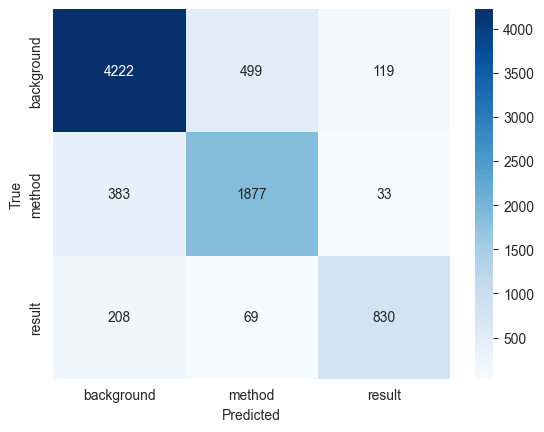

              precision    recall  f1-score   support

  background       0.88      0.87      0.87      4840
      method       0.77      0.82      0.79      2293
      result       0.85      0.75      0.79      1107

    accuracy                           0.84      8240
   macro avg       0.83      0.81      0.82      8240
weighted avg       0.84      0.84      0.84      8240


In [26]:
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true_train, y_pred_train, average='macro')
cm_eval = confusion_matrix(y_true_train, y_pred_train)
report = classification_report(y_true_train, y_pred_train, target_names=label_list)

print("Evaluation on Training dataset")
print('F1 score: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)

In [29]:
y_true_val, y_pred_val = [], []
for x, y in val_features_dataloader:
    x, y = x.to(device), y.to(device)
    
    log_probs = feature_classifier(x)
    
    y_batch_pred = torch.argmax(log_probs, dim=1)
    
    y_true_val += list(y.cpu().numpy())
    y_pred_val += list(y_batch_pred.cpu().numpy())

Evaluation on Training dataset
F1 score: 0.854


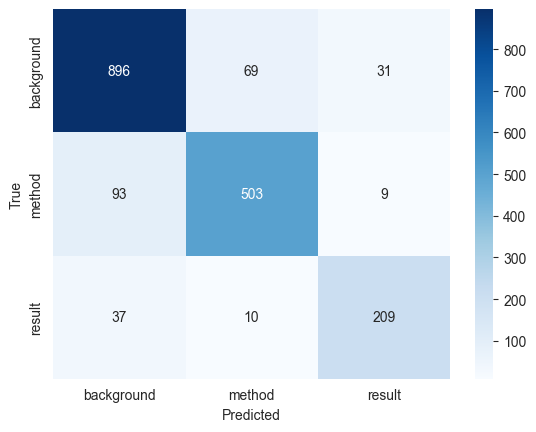

              precision    recall  f1-score   support

  background       0.87      0.90      0.89       996
      method       0.86      0.83      0.85       605
      result       0.84      0.82      0.83       256

    accuracy                           0.87      1857
   macro avg       0.86      0.85      0.85      1857
weighted avg       0.87      0.87      0.87      1857


In [30]:
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true_val, y_pred_val, average='macro')
cm_eval = confusion_matrix(y_true_val, y_pred_val)
report = classification_report(y_true_val, y_pred_val, target_names=label_list)

print("Evaluation on Validation dataset")
print('F1 score: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)